[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/codeteme/img_clf_data_sprint_51/blob/main/scripts/model.ipynb)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pathlib
import os
import PIL
import PIL.Image

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = "../data/raw/animal_dataset_intermediate/train"
data_dir = pathlib.Path(data_dir)
print(data_dir)

../data/raw/animal_dataset_intermediate/train


In [4]:
batch_size = 32
img_height = 256
img_width = 256

Let's check if OS and PIL libraries are correctly reading and displying the images. 

In [5]:
class_names = ['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo']

In [6]:
with open('../data/interim/img_as_array.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f)
    x_val = np.load(f)
    y_val = np.load(f)

In [7]:
assert isinstance(x_train, (np.ndarray, np.generic))
assert isinstance(y_train, (np.ndarray, np.generic))
assert isinstance(x_val, (np.ndarray, np.generic))
assert isinstance(y_val, (np.ndarray, np.generic))

assert x_train.ndim, x_val == 4
assert y_train.ndim, y_train.ndim == 1

/Users/tmt0947/opt/anaconda3/envs/csx433env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


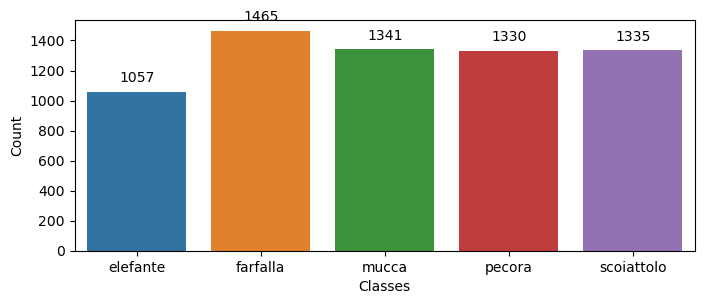

In [8]:
#TODO: Data viz to show data imbalance - bar graph

plt.figure(figsize=(8, 3))
splot = sns.countplot(y_train)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

splot.set_xticklabels(class_names)
splot.set_xlabel("Classes")
splot.set_ylabel("Count")
plt.show()

In [9]:
from sklearn.utils import resample 

print("-" * 70)
print('Input shape before resampling: ' ,x_train.shape, y_train.shape)

#..reshape (flatten) x_train for SMOTE resampling
nsamples, k, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,k*nx*ny))
x_train.shape

from imblearn.over_sampling import SMOTE
smote = SMOTE('all')
x_train, y_train = smote.fit_resample(x_train, y_train)

print("-" * 70)
print('Input shape after sampling: ' ,x_train.shape, y_train.shape)
print('Class distribution after over-sampling: ')
for i in range(len(class_names)):
    print(f'Number of class {class_names[i]} examples before:{x_train[y_train == i].shape[0]}')

----------------------------------------------------------------------
Input shape before resampling:  (6528, 256, 256, 3) (6528,)


/Users/tmt0947/opt/anaconda3/envs/csx433env/lib/python3.9/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=all as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


----------------------------------------------------------------------
Input shape after sampling:  (7325, 196608) (7325,)
Class distribution after over-sampling: 
Number of class elefante examples before:1465
Number of class farfalla examples before:1465
Number of class mucca examples before:1465
Number of class pecora examples before:1465
Number of class scoiattolo examples before:1465


/Users/tmt0947/opt/anaconda3/envs/csx433env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


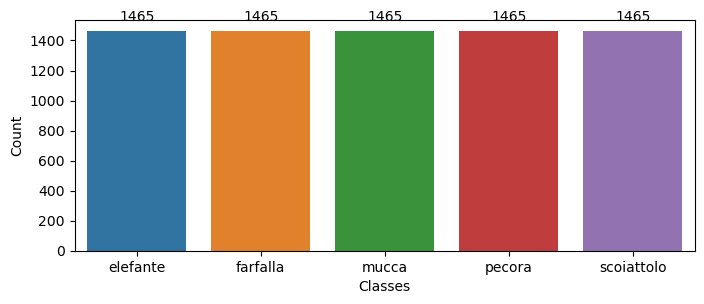

In [10]:
plt.figure(figsize=(8, 3))
splot = sns.countplot(y_train)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

splot.set_xticklabels(class_names)
splot.set_xlabel("Classes")
splot.set_ylabel("Count")
plt.show()

In [11]:
# return to original 4D shape
x_train = x_train.reshape(7325, k, nx, ny)


In [12]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.1),layers.RandomZoom(0.1),
    layers.RandomContrast((0.1, 0.9)),
    ])

assert(x_train.ndim == 4) # Check if augementation affected shape

In [14]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [15]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

E1024 13:52:59.301454 4720590272 program.py:298] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [16]:
# num_classes = 5

# def build_model(n_hidden=1, n_neurons=30, learning_rate=0.0003, input_shape=[7325, 256, 256, 3]):
#     model = keras.models.Sequential(data_augmentation),
#     tf.keras.layers.Rescaling(1./255),
#     model.add(keras.layers.InputLayer(input_shape=input_shape))
#     for layer in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation="relu"))
#     tf.keras.layers.Dropout(learning_rate)
#     model.add(keras.layers.Dense(num_classes))

#     optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
#     model.compile(
#         # optimizer=optimizer,
#         optimizer='adam',
#         loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
#         metrics=['accuracy']
#         )
#     return model

# keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import reciprocal

# param_distribs = {
#     "n_hidden": [0, 1, 2, 3],
#     "n_neurons": np.arange(1, 100)               .tolist(),
#     "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
# }


# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

# rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=3)
# history = rnd_search_cv.fit(x_train, y_train, epochs=100,
#                   validation_data=(x_val, y_val),
#                   callbacks=[keras.callbacks.EarlyStopping(patience=10), checkpoint_cb, tensorboard_cb])

In [18]:
num_classes = 5

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2), # Dropout https://www.tensorflow.org/tutorials/images/classification#dropout
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
  )


# Two callbacks options to implement early Stopping to avoid overfitting. 

#1. keras.callbacks.ModelCheckpoint() saves the model when its performance on the validation set is the best so far

#2. keras.callbacks.EarlyStopping() interrupts training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model.

It's possible to  combine both callbacks to save checkpoints of your model (in case the computer crashes) and interrupt training early when there is no more progress (to avoid wasting time and resources)

In [40]:
epochs = 50
checkpoint_cb = keras.callbacks.ModelCheckpoint("saved_model/keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history =  model.fit(
  x_train, y_train,
  validation_data=(x_val, y_val),
  epochs=epochs,
  callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb]
)


checkpoint_cb saves the best model. Just in case, though, we'll also save the final model

In [77]:
model.save('../saved_model/best_model') 

INFO:tensorflow:Assets written to: ../saved_model/best_model/assets


In [68]:
model.evaluate(x_val, y_val, verbose=2) # ~78% accuracy

51/51 - 14s - loss: 1.6208 - accuracy: 0.2016


[1.6207958459854126, 0.20159313082695007]

In [20]:
new_model = tf.keras.models.load_model('../my_keras_model.h5')
new_model.evaluate(x_val, y_val, verbose=2) # ~78% accuracy


51/51 - 14s - loss: 0.5761 - accuracy: 0.7819


[0.5761368870735168, 0.781862735748291]

In [ ]:
# TODO: Calculate validation accuracy per class. 


In [21]:
import pandas as pd

pd.options.display.max_colwidth = 999

../data/raw/animal_dataset_intermediate/test
Imported image_count:  896


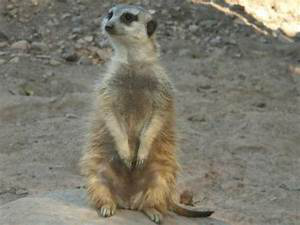

In [22]:
test_data_dir = "../data/raw/animal_dataset_intermediate/test"
test_data_dir = pathlib.Path(test_data_dir)
print(test_data_dir)

image_count = len(list(test_data_dir.glob('*.jpg')) + list(test_data_dir.glob('*.jpeg')))
print("Imported image_count: ", image_count)

picture = list(test_data_dir.glob('*'))
PIL.Image.open(str(picture[0]))

In [ ]:
df_submission_filename = pd.read_csv("../data/raw/animal_dataset_intermediate/Testing_set_animals.csv")

classes = []

df_len = df_submission_filename.shape[0]
for i in range(df_len): 
    path = os.path.join(test_data_dir, df_submission_filename.loc[i][0])
    img = tf.keras.utils.load_img(
        path, grayscale=False, color_mode='rgb', target_size=(img_height, img_width),
        interpolation='nearest'
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array.reshape(1, k, nx, ny)
    predict_img = model.predict(img_array) 
    classes_img = np.argmax(predict_img,axis=1)
    classes.append(classes_img[0])


In [ ]:
df_submission_filename['target'] = [class_names[num] for num in list(classes)]
df_submission_filename.head()

In [ ]:
# df_submission_filename.to_csv("submission/submission.csv", index=False)